# 🎸Musical Chords Classification and Identifier

This is a small demonstration fo how the big Classifier is going to look Since till now we have not collected enough data to build a larger identifier project so let's look at Small one

### Aim of this notebook

* Look into collected dataset
* Visualization of different chords
* Different Audio processing techniques and their effect on model 
* audio file to Waveform
* waveform to Spectrogram
* Label engineering
* Model building 
* Model Fitting
* Model Evaluating on different processing
* Trying to predict on custom data 

**🔑Note**: This will also going to be the aims of bigger project

### 1. Look into Collected Dataset

In [1]:
# Import all modules
import numpy as np
import pandas  as pd
import os
import random
import matplotlib.pyplot as plt

In [2]:
# define path
DATAPATH = "dataset_chords"
# let's walk through it
for dirpath, dirname, filename in os.walk(DATAPATH): 
    print(f"There are {len(dirname)} directories and {len(filename)} files at `{dirpath}`")

There are 3 directories and 0 files at `dataset_chords`
There are 0 directories and 100 files at `dataset_chords\A`
There are 0 directories and 112 files at `dataset_chords\C`
There are 0 directories and 100 files at `dataset_chords\F`


Means here we only have 3 Chords `A major`, `C major`, `F major`

Important things need to know before loading file
what is the sample_rate of file

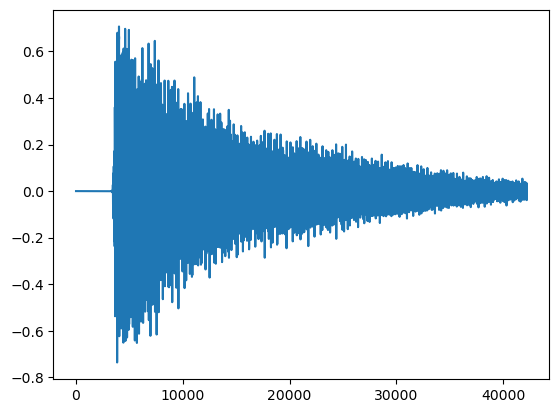

In [3]:
# sampling_rate
import tensorflow as tf
import tensorflow_io as tfio
import librosa as lb
chord_path = os.path.join(DATAPATH, 'A')
random_file = random.sample(os.listdir(chord_path), 1)[0]
file_path = os.path.join(chord_path, random_file)
wav, sr = lb.load(file_path, sr = 16000)
plt.plot(wav);

In [4]:
from IPython.display import Audio
Audio(wav, rate = 16000)

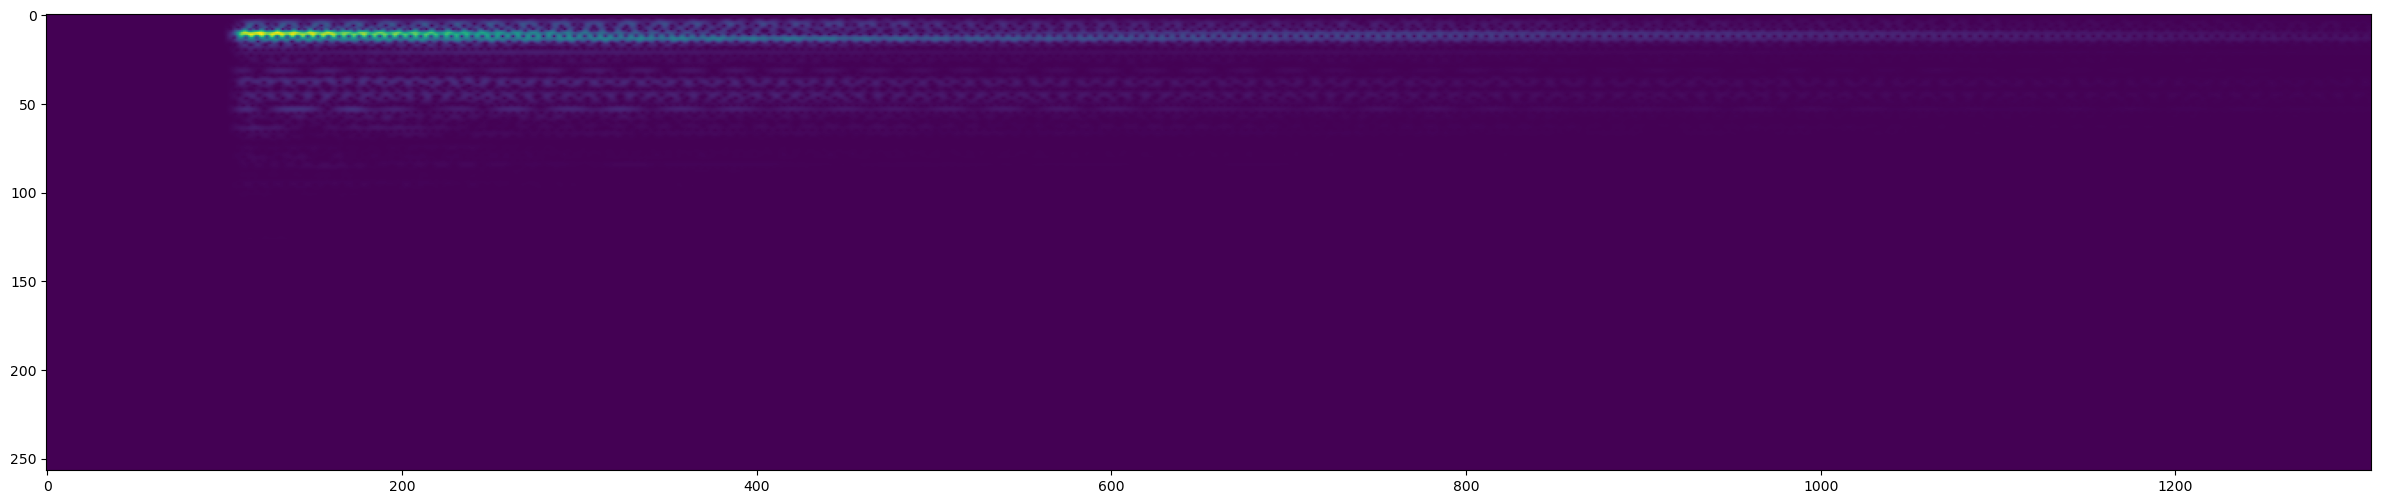

In [5]:
wav = tf.constant(wav)
spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis = 2)
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spectrogram)[0])

In [6]:
file_path

'dataset_chords\\A\\a90.wav'

In [7]:
len(wav)/sr, len(wav)

(2.64, 42240)

In [8]:
# let's create some function to load image and to convert into spectrogram and also a preprocessing function to also help wo this on dataset
def load_wav_file(filepath, waveform = True, name = "Audio file"): 
    """
    This function will load the audio file into 16Khz sampling rate
    
    returns wav file in tensorflow format
    """
    wav, rate = lb.load(filepath, sr = 16000)
    wav = tf.constant(wav)
    if waveform: 
        plt.plot(wav, label= name)
        plt.legend()
        plt.show()
    return wav

def convert_wav_to_spectrogram(wav,name = "Spectrogram",show = True, frame_length = 320, frame_step = 32, average_length = 35000):
    """
    convert tensorflow formated wav file to spectrogram of desired framelenght and fram steps
    
    also convert them to a average length and if not them add padding to them
    
    and returns spectrogram with mono channel
    """
    wav = wav[:average_length]
    #add zero padding at end
    zero_padding = tf.zeros([average_length] - tf.shape(wav), dtype = tf.float32)
    # concate that to audio file at end
    wav = tf.concat([wav, zero_padding], 0)
    # Create spectrogram of wavefrom file
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    #convert to absolute form
    spectrogram = abs(spectrogram)
    #Expand dims for adding channel (mono audio) 1
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    if show:
        plt.figure(figsize = (30, 20))
        plt.imshow(tf.transpose(spectrogram)[0])
        plt.title(name)
        plt.show()
    return spectrogram

def preprocessing(filepath, labels): 
    wav = load_wav_file(filepath, waveform=False)
    spectrogram = convert_wav_to_spectrogram(wav,show=False)
    return spectrogram, labels

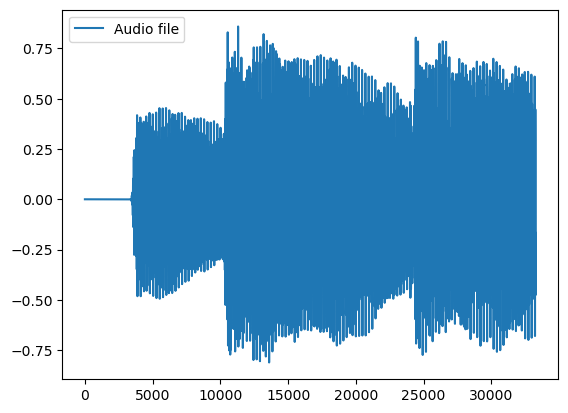

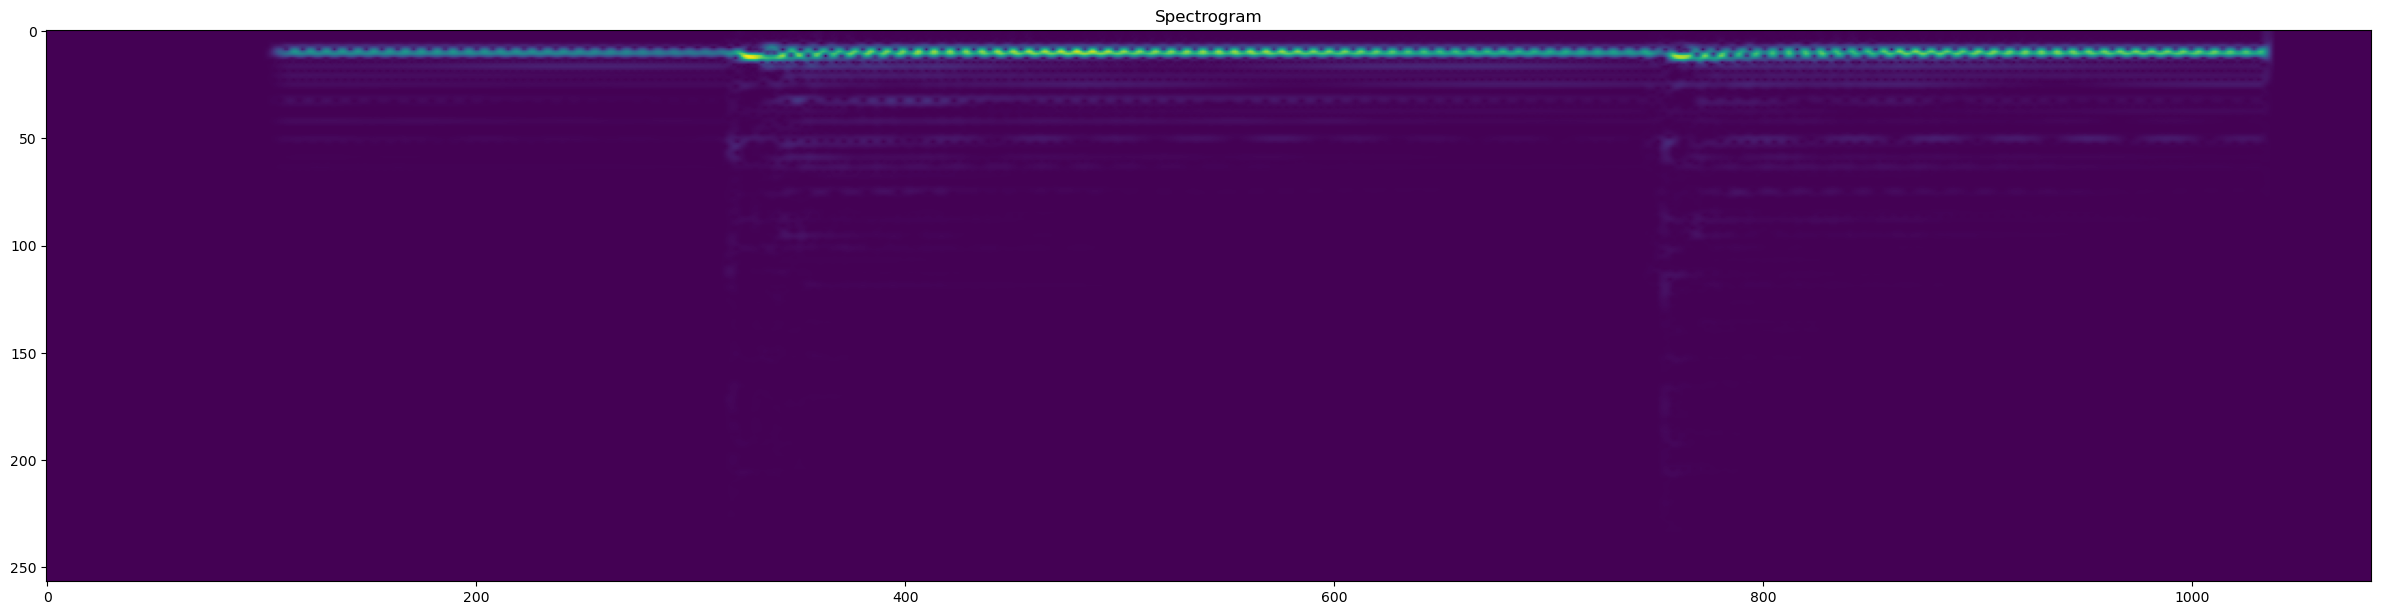

In [9]:
wav = load_wav_file('dataset_chords\\C\\c07.wav')
spectrogram = convert_wav_to_spectrogram(wav)

-------------------------------
For A Chord
Waveform of file : a27.wav


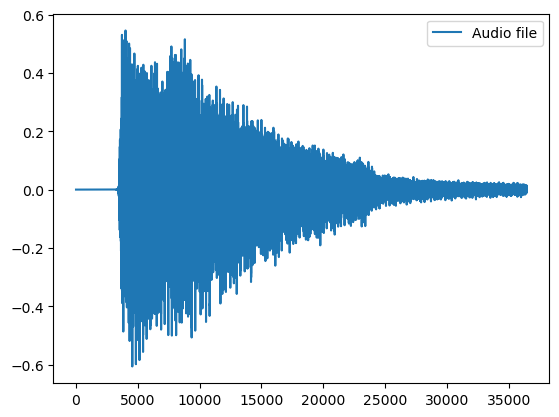

Spectrogram of file: a27.wav


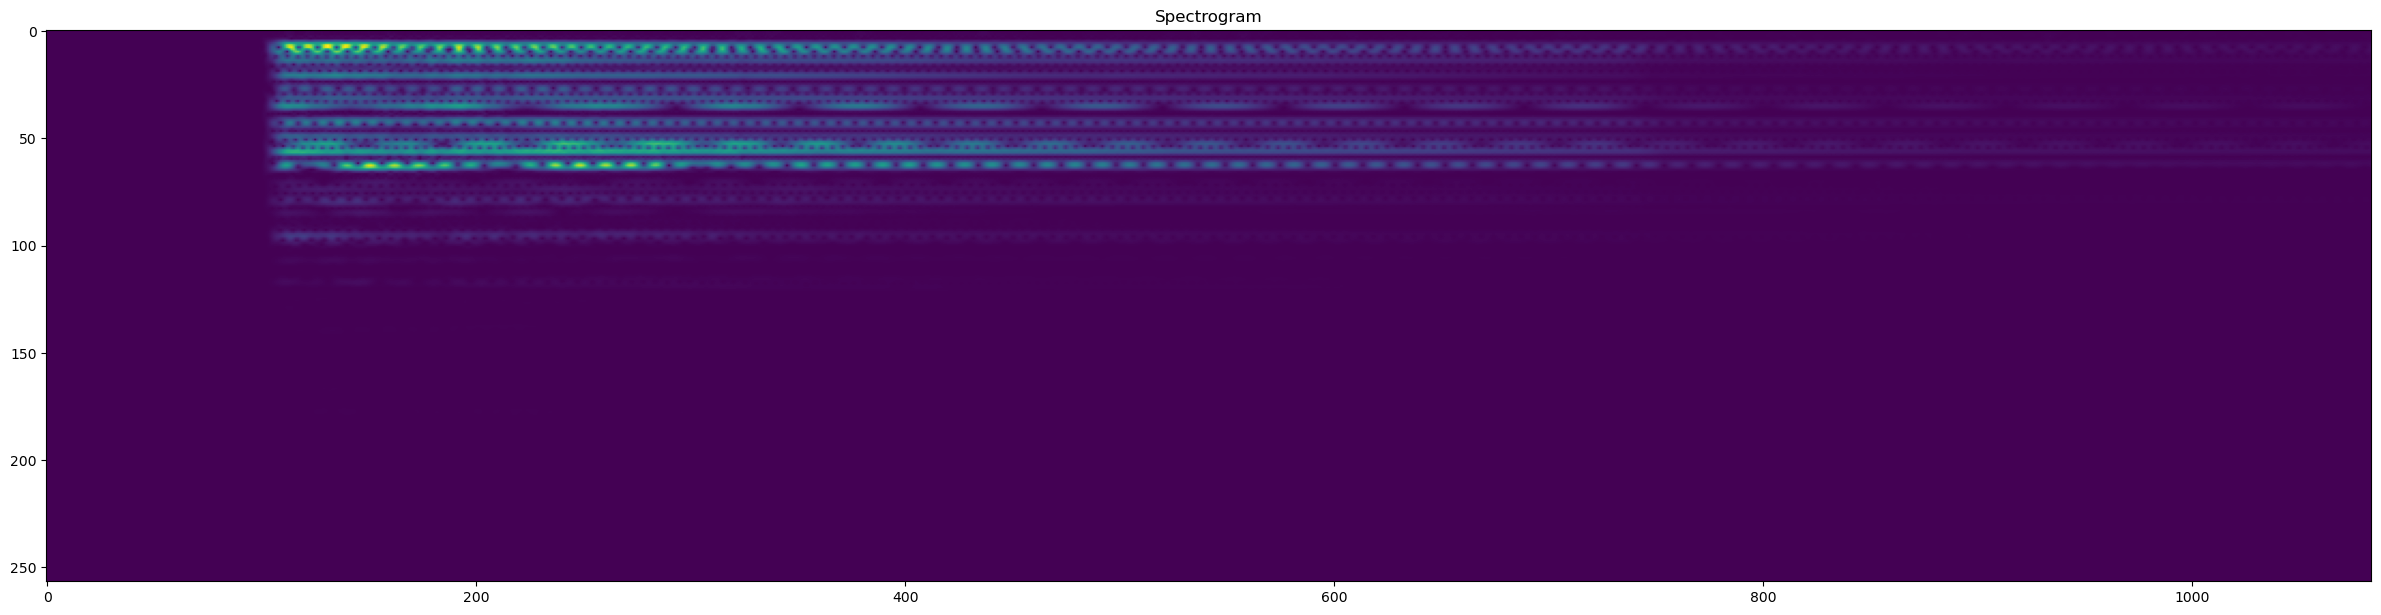

-------------------------------
For C Chord
Waveform of file : c47.wav


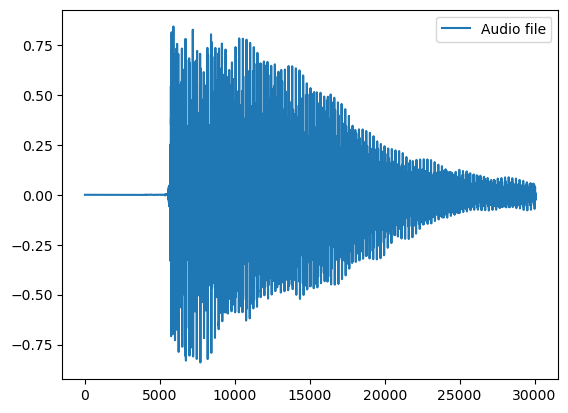

Spectrogram of file: c47.wav


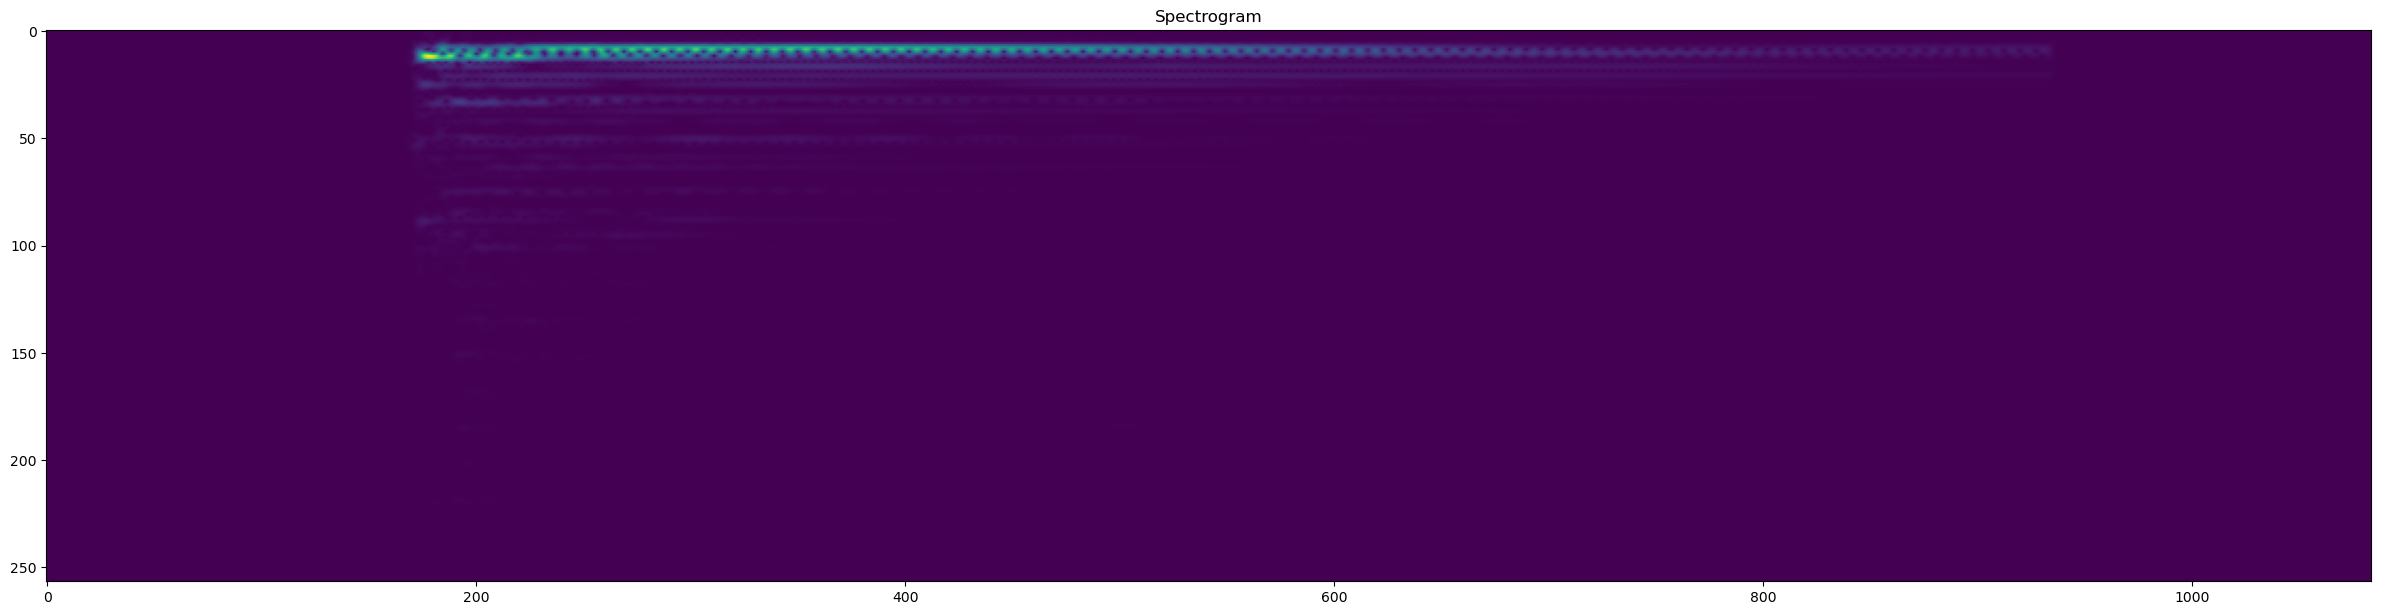

-------------------------------
For F Chord
Waveform of file : f72.wav


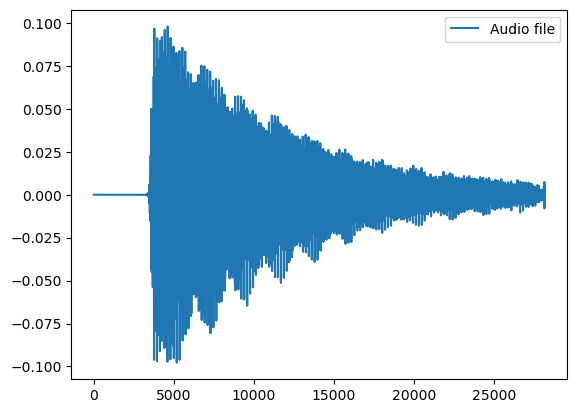

Spectrogram of file: f72.wav


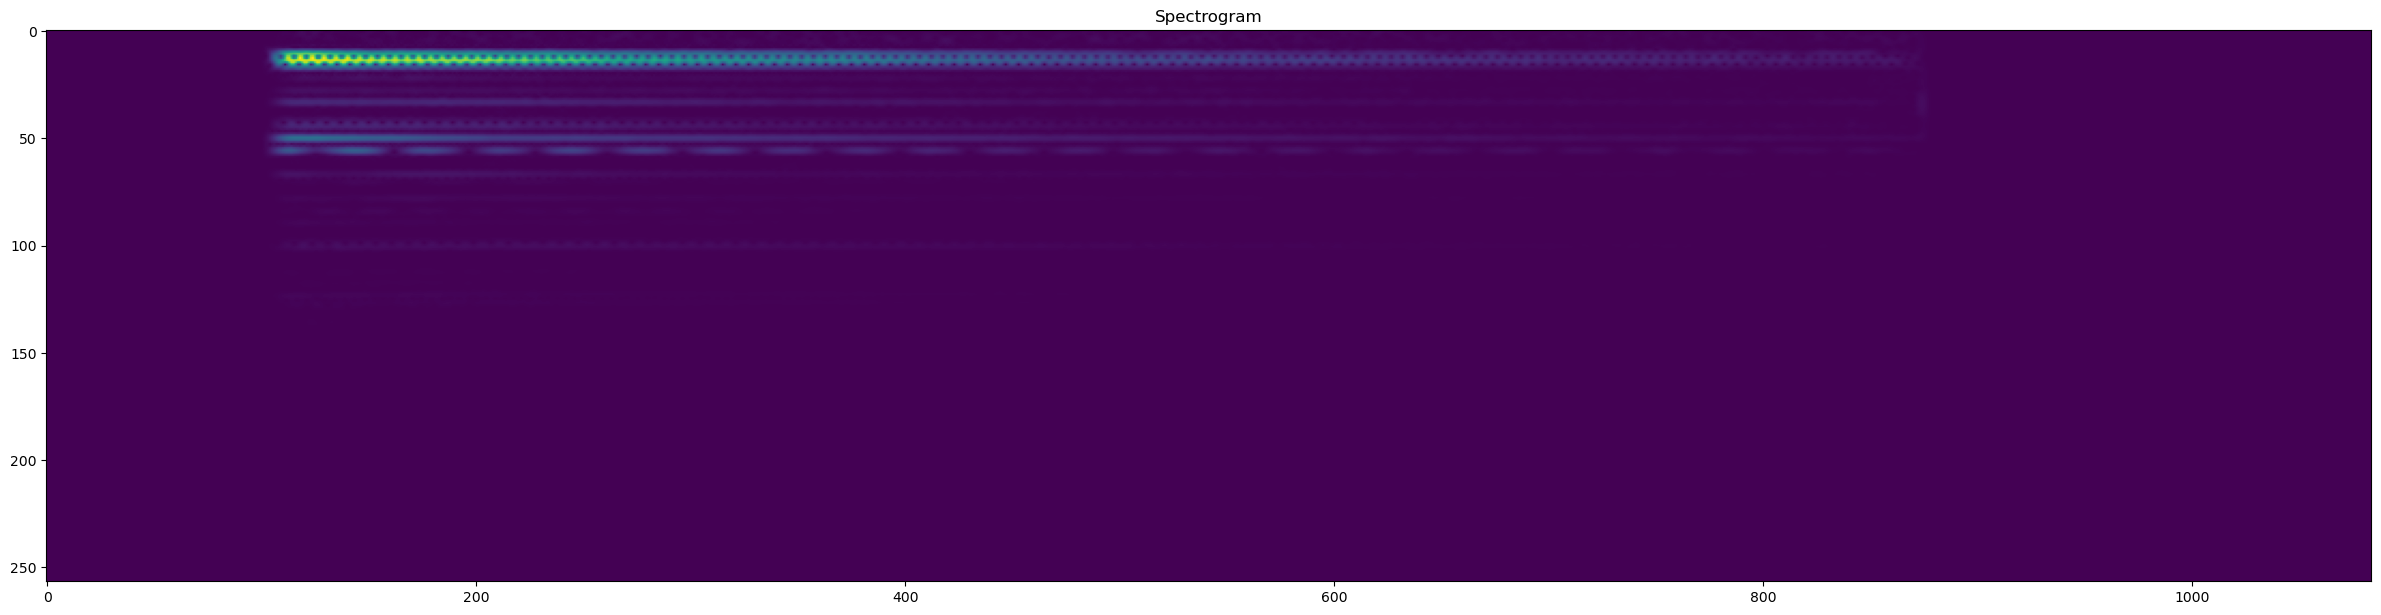

In [10]:
# Let's try to listen random files from all three directories
from IPython.display import Audio

for chord in os.listdir(DATAPATH): 
    chord_path = os.path.join(DATAPATH, chord)
    random_file = random.sample(os.listdir(chord_path), 1)[0]
    print(f"-------------------------------\nFor {chord} Chord")
    file_path = os.path.join(chord_path, random_file)
    print(f"Waveform of file : {random_file}")
    wav = load_wav_file(file_path)
    print(f"Spectrogram of file: {random_file}")
    spectrogram = convert_wav_to_spectrogram(wav)

## Create Tensorflow dataset

In [12]:
from tqdm import tqdm
label = 0
for chord in tqdm(os.listdir(DATAPATH)): 
    chord_path = os.path.join(DATAPATH, chord)
    chord_data = tf.data.Dataset.list_files(chord_path+"/*.wav")
    labels = tf.data.Dataset.from_tensor_slices(tf.constant([label for i in range(len(chord_data))]))
    if label == 0: 
        data = tf.data.Dataset.zip((chord_data,labels))
    else: 
        data = data.concatenate(tf.data.Dataset.zip((chord_data, labels)))
    label+=1
    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.99it/s]


In [14]:
data.shuffle(len(data)).as_numpy_iterator().next()

(b'dataset_chords\\F\\f51.wav', 2)

## Determine the average length of audio file to get the most appropriate cut

In [15]:
lengths = []
for chord in tqdm(os.listdir(DATAPATH)): 
    for file in os.listdir(os.path.join(DATAPATH, chord)): 
        wav = load_wav_file(os.path.join(DATAPATH, chord, file), waveform = False)
        lengths.append(len(wav))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


In [16]:
lengths[:10]

[28160, 32000, 34560, 50560, 30720, 43520, 32000, 37760, 40960, 39680]

### Calculate min max and average

In [17]:
mean = tf.reduce_mean(lengths).numpy()
mean

35187

In [18]:
max = tf.reduce_max(lengths).numpy()
max

75520

In [19]:
min = tf.reduce_min(lengths).numpy()
min

22400

In [20]:
import numpy as np
lengths.sort()
median = lengths[len(lengths)//2]
median    

34560

#### 35000 is a good number for average content

In [21]:
RATE = 16000
print(f"Average length of Audio files: {mean/RATE :.2f}s")
print(f"Maximum length of Audio files: {max/RATE}s")
print(f"Minimum length of Audio files: {min/RATE}s")

Average length of Audio files: 2.20s
Maximum length of Audio files: 4.72s
Minimum length of Audio files: 1.4s


In [22]:
filepath, label = data.shuffle(len(data)).as_numpy_iterator().next()
spectrogram ,label = preprocessing(filepath, label)

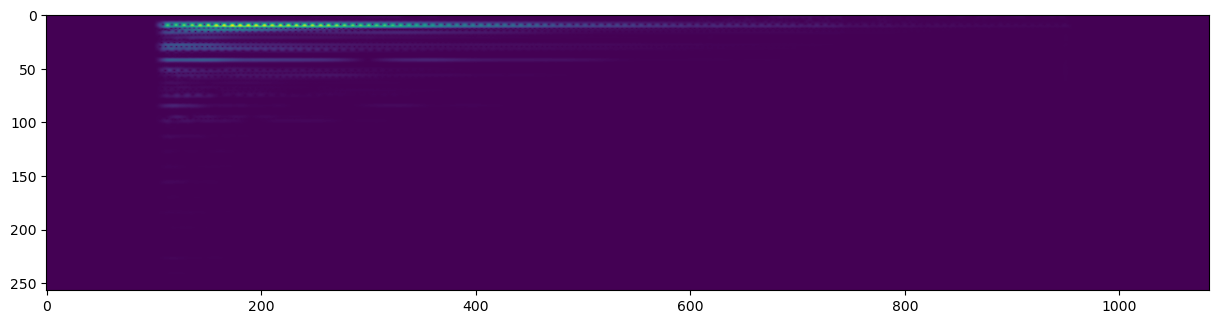

In [23]:
plt.figure(figsize = (15, 7))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

**This all is working like a Charm**

Let's try to train at mode and see how it goes

## Load all data

In [30]:
label = 0
for chord in os.listdir(DATAPATH): 
    chord_path = os.path.join(DATAPATH, chord)
    chord_data = []
    for file in tqdm(os.listdir(chord_path)): 
        wav = load_wav_file(os.path.join(chord_path, file), waveform=False)
        spectrogram = convert_wav_to_spectrogram(wav, show = False)
        chord_data.append(spectrogram)
    labels = tf.data.Dataset.from_tensor_slices(tf.constant([label for i in range(len(chord_data))]))
    chord_data = tf.data.Dataset.from_tensor_slices(chord_data)
    if label == 0: 
        data = tf.data.Dataset.zip((chord_data, labels))
    else: 
        data = data.concatenate(tf.data.Dataset.zip((chord_data, labels)))
    label+=1
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.40it/s]


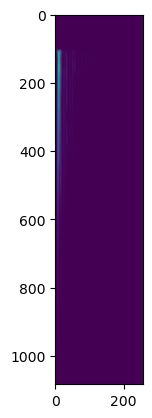

In [25]:
spectrogarm , label = data.shuffle(len(data)).as_numpy_iterator().next()
plt.imshow(spectrogram), label;

In [26]:
len(data)

312

## Create data batchs

In [31]:
batch_size = 16
data = data.shuffle(len(data)).batch(batch_size)

In [32]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1084, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1084, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
len(data)

20

In [35]:
# let's use two batch for testing and other for training
Take = np.round(len(data)* 0.8)
train = data.take(Take)
test = data.skip(Take).take(len(data) - Take)

In [36]:
len(train)

16

In [37]:
len(test)

4

## Test one batch

In [38]:
samples , labels = train.as_numpy_iterator().next()

In [39]:
samples.shape

(16, 1084, 257, 1)

In [40]:
labels

array([1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2])

## Build Deep learning model

In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

In [61]:
model = Sequential([
    Conv2D(64, 3, activation = 'relu', input_shape = (1084, 257, 1)),
    Conv2D(64, 3, activation = 'relu', padding='same'),
    MaxPool2D(pool_size = 2),
    Conv2D(32, 3, activation = 'relu', padding = 'same'),
    Conv2D(32, 3, activation = 'relu', padding = 'same'),
    MaxPool2D(),
    Conv2D(10, 3, activation = 'relu', padding = 'valid'),
    Conv2D(10, 3, activation = 'relu', padding = 'valid'),
    MaxPool2D(),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(len(os.listdir(DATAPATH)), activation = 'softmax')
])
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 1082, 255, 64)     640       
                                                                 
 conv2d_31 (Conv2D)          (None, 1082, 255, 64)     36928     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 541, 127, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 541, 127, 32)      18464     
                                                                 
 conv2d_33 (Conv2D)          (None, 541, 127, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 270, 63, 32)       0         
 ng2D)                                                

In [63]:
from tensorflow.keras.callbacks import EarlyStopping
 
earlyStopping = EarlyStopping(monitor = 'val_accuracy', patience=3)
history = model.fit(train,
                    epochs = 25,
                    validation_data = test, 
                   callbacks=[earlyStopping])

Epoch 1/25
16/16 [==============================] - 201s 13s/step - loss: 1.0289 - accuracy: 0.4297 - val_loss: 0.7986 - val_accuracy: 0.6071
Epoch 2/25
16/16 [==============================] - 194s 12s/step - loss: 0.6954 - accuracy: 0.7109 - val_loss: 0.4346 - val_accuracy: 0.8036
Epoch 3/25
16/16 [==============================] - 189s 12s/step - loss: 0.3796 - accuracy: 0.8438 - val_loss: 0.3280 - val_accuracy: 0.8750
Epoch 4/25
16/16 [==============================] - 241s 15s/step - loss: 0.2409 - accuracy: 0.9023 - val_loss: 0.1983 - val_accuracy: 0.9107
Epoch 5/25
16/16 [==============================] - 217s 14s/step - loss: 0.1155 - accuracy: 0.9688 - val_loss: 0.1217 - val_accuracy: 0.9821
Epoch 6/25
16/16 [==============================] - 221s 14s/step - loss: 0.0870 - accuracy: 0.9766 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 7/25
16/16 [==============================] - 206s 13s/step - loss: 0.1420 - accuracy: 0.9688 - val_loss: 0.0809 - val_accuracy: 0.9643
Epoch 

In [64]:
model.evaluate(test)

4/4 [==============================] - 8s 2s/step - loss: 0.0903 - accuracy: 0.9464


[0.09031447023153305, 0.9464285969734192]

In [65]:
sample, label = test.as_numpy_iterator().next()
pred = model.predict(sample)

1/1 [==============================] - 3s 3s/step


In [66]:
pred

array([[1.0000000e+00, 2.6198767e-11, 1.3041603e-09],
       [3.8515576e-04, 6.8058952e-08, 9.9961472e-01],
       [9.0761149e-01, 9.0878569e-02, 1.5099652e-03],
       [9.5763372e-04, 9.2365164e-03, 9.8980588e-01],
       [2.7532340e-06, 9.9999714e-01, 1.0408229e-07],
       [4.4085806e-19, 1.0000000e+00, 7.4834399e-13],
       [2.8222335e-12, 1.0000000e+00, 1.6742948e-08],
       [3.3696143e-08, 9.9999678e-01, 3.2517551e-06],
       [8.8373612e-04, 9.9866712e-01, 4.4915103e-04],
       [7.8204221e-10, 1.0000000e+00, 2.2831517e-13],
       [2.0738988e-12, 9.8422706e-02, 9.0157729e-01],
       [9.9999976e-01, 6.8226567e-09, 1.9305197e-07],
       [2.1669555e-11, 1.0000000e+00, 5.0895540e-14],
       [1.3797643e-19, 1.0000000e+00, 2.2294377e-09],
       [9.8539114e-01, 1.3342695e-02, 1.2661447e-03],
       [3.5749719e-12, 9.9999952e-01, 5.2731457e-07]], dtype=float32)

In [67]:
np.argmax(pred, axis = 1)

array([0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1], dtype=int64)

In [68]:
label

array([0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1])

## Visualize model Training

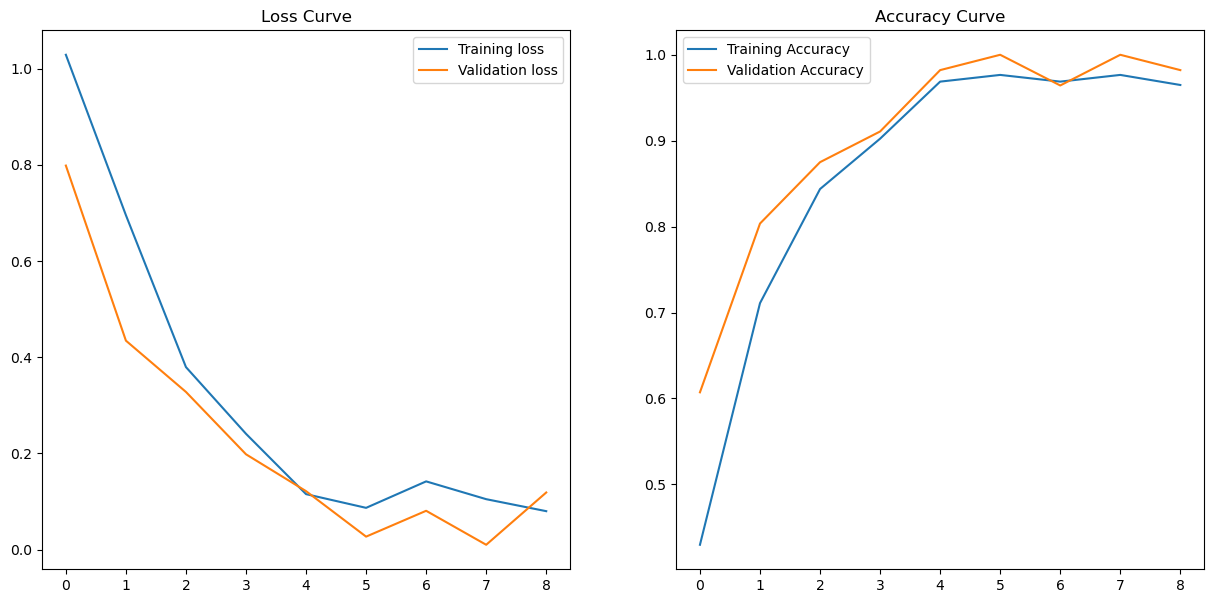

In [69]:
# Let's build loss and accuracy curve seperately

fig, ax = plt.subplots(1, 2,figsize =(15, 7))
History = pd.DataFrame(history.history)
ax[0].plot(History["loss"], label = "Training loss");
ax[0].plot(History['val_loss'], label = "Validation loss");
ax[0].set(title = "Loss Curve")
ax[0].legend();
ax[1].plot(History["accuracy"], label = "Training Accuracy");
ax[1].plot(History['val_accuracy'], label = "Validation Accuracy");
ax[1].set(title = "Accuracy Curve")
ax[1].legend();

In [70]:
# Create function to convert prediction to labels
def convert_pred_label(y_pred): 
    y_pred = np.argmax(y_pred, axis = 1)
    labels = os.listdir(DATAPATH)
    results = [[labels[x]] for x in y_pred]
    return np.array(results)
def show_label_with_pred_prob(y_pred): 
    chords = convert_pred_label(y_pred)
    label_index = np.argmax(y_pred, axis = 1)
    pred_prob = np.array([[y_pred[i][label_index[i]]] for i in range(len(y_pred))])
    result = np.hstack((chords, pred_prob))
    return result
def convert_prob_label_index(y_pred): 
    return np.argmax(y_pred, axis = 1)

In [71]:
show_label_with_pred_prob(pred)

array([['A', '1.0'],
       ['F', '0.9996147'],
       ['A', '0.9076115'],
       ['F', '0.9898059'],
       ['C', '0.99999714'],
       ['C', '1.0'],
       ['C', '1.0'],
       ['C', '0.9999968'],
       ['C', '0.9986671'],
       ['C', '1.0'],
       ['F', '0.9015773'],
       ['A', '0.99999976'],
       ['C', '1.0'],
       ['C', '1.0'],
       ['A', '0.98539114'],
       ['C', '0.9999995']], dtype='<U32')

In [72]:
convert_pred_label(pred)[:,-1]

array(['A', 'F', 'A', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'F', 'A', 'C',
       'C', 'A', 'C'], dtype='<U1')

In [73]:
convert_prob_label_index(pred)

array([0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1], dtype=int64)

## Let's try to make predictions on custom data

In [74]:
def make_pred_custom_chord(filepath, model): 
    wav = load_wav_file(filepath)
    spectrogram = convert_wav_to_spectrogram(wav)
    pred = model.predict(tf.expand_dims(spectrogram, axis = 0))
    return show_label_with_pred_prob(pred)

In [75]:
from tensorflow.keras.models import load_model
model = load_model("models/Classifier_ACF.keras")

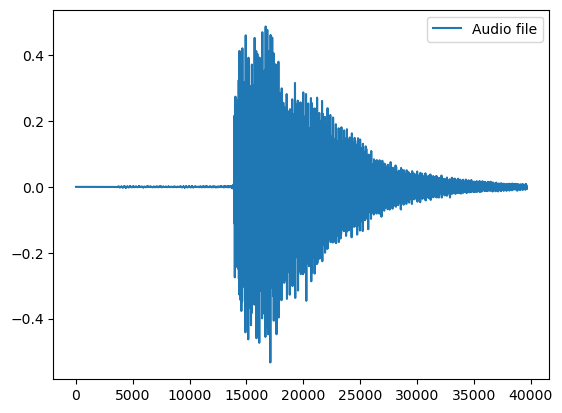

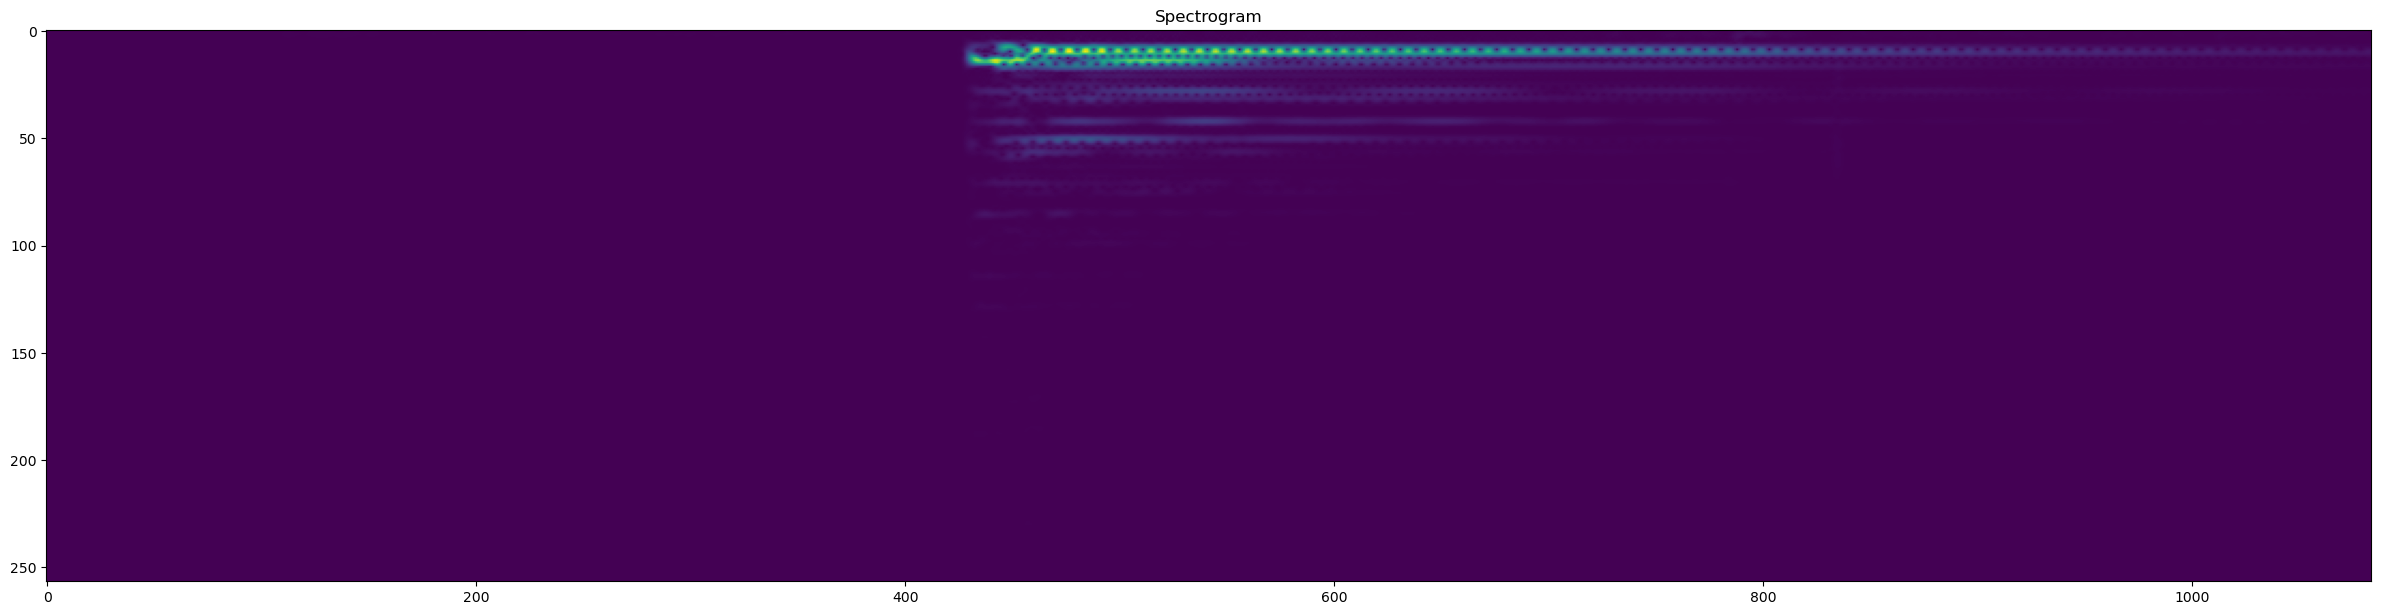

1/1 [==============================] - 0s 73ms/step


In [77]:
results = make_pred_custom_chord(r"C:\Mitsgwl\sem 5\Minor_project\dataset_chords\A\a94.wav", model = model)

In [96]:
classes = os.listdir(os.path.join(DATAPATH))
i = 0
for chord, precentage in results:
    write  = "{} {:.2f}%".format(chord, float(precentage)*100)
#     st.sidebar.write(write)
    print(write)
    i+=1

A 89.59%


In [97]:
results

array([['A', '0.895862']], dtype='<U32')

In [98]:
save_path = "C:/Mitsgwl/sem 5/Minor_project/models/Classifier_ACF_25_epochs.keras"

In [99]:
# Save the model 

model.save(save_path)

In [100]:
# laod model 
def load_model(path): 
    return tf.keras.saving.load_model(path)

In [101]:
loaded_model = load_model(save_path)

In [102]:
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 1082, 255, 32)     320       
                                                                 
 conv2d_31 (Conv2D)          (None, 1082, 255, 32)     9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 541, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 541, 127, 16)      4624      
                                                                 
 conv2d_33 (Conv2D)          (None, 541, 127, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 270, 63, 16)       0         
 ng2D)                                                

In [103]:
sample, label = test.as_numpy_iterator().next()
pred = loaded_model.predict(sample)
pred

1/1 [==============================] - 1s 974ms/step


array([[6.7159664e-03, 6.0060352e-01, 3.9268044e-01],
       [2.2630271e-01, 1.7729715e-01, 5.9640014e-01],
       [2.8080810e-03, 9.9718082e-01, 1.1130016e-05],
       [9.2462709e-05, 9.9908173e-01, 8.2577980e-04],
       [3.6083981e-03, 1.2749973e-03, 9.9511659e-01],
       [9.9313170e-01, 4.2941417e-03, 2.5741125e-03],
       [3.9810488e-09, 1.5154756e-08, 1.0000000e+00],
       [9.9664307e-01, 1.4966464e-03, 1.8602987e-03],
       [9.9843282e-01, 1.5660666e-03, 1.0977074e-06],
       [3.6045241e-01, 2.9089552e-01, 3.4865201e-01],
       [1.1599592e-08, 2.7481701e-05, 9.9997246e-01],
       [2.1835652e-01, 2.7805182e-01, 5.0359166e-01],
       [1.3146022e-01, 6.3223785e-01, 2.3630193e-01],
       [8.9586192e-01, 9.0757899e-02, 1.3380268e-02],
       [9.9999809e-01, 5.3951875e-14, 1.9187742e-06],
       [6.1097060e-04, 9.9020678e-01, 9.1822222e-03]], dtype=float32)

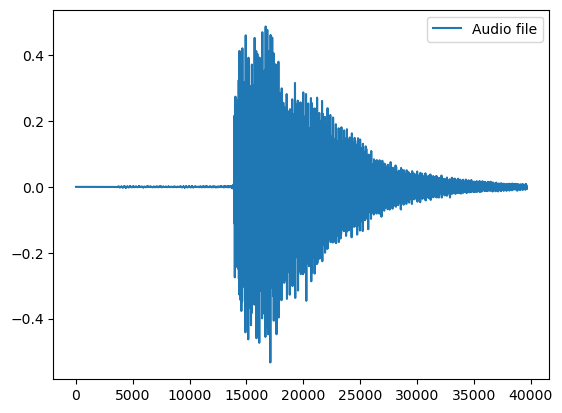

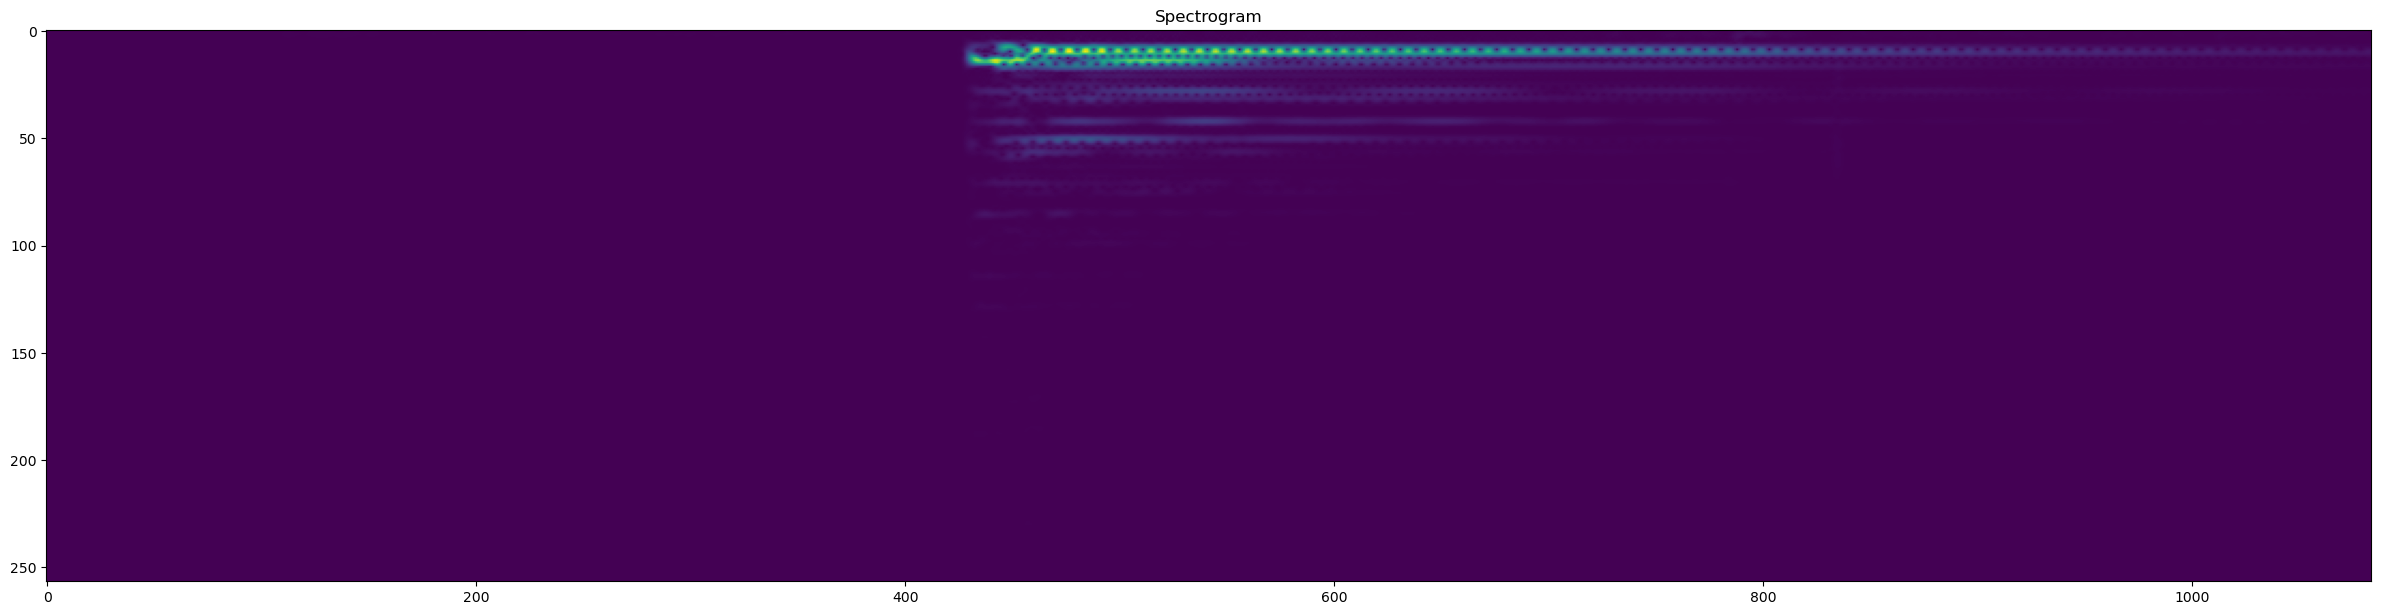

1/1 [==============================] - 0s 72ms/step


array([['A', '0.895862']], dtype='<U32')

In [104]:
make_pred_custom_chord("dataset_chords/A/a94.wav", model =loaded_model)

In [105]:
wav = load_wav_file("dataset_chords/A/a94.wav", waveform=False)
Audio(wav, rate = 16000)

let's try the prediction on the mp3 file also 

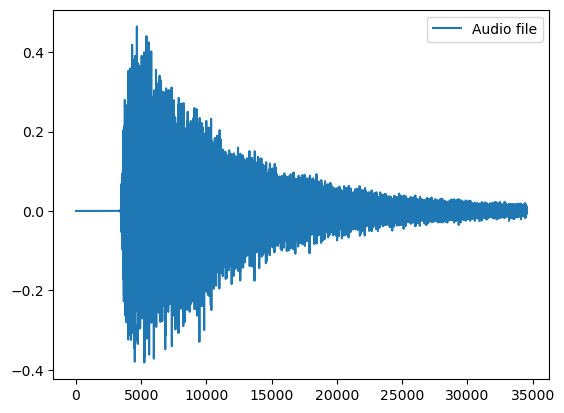

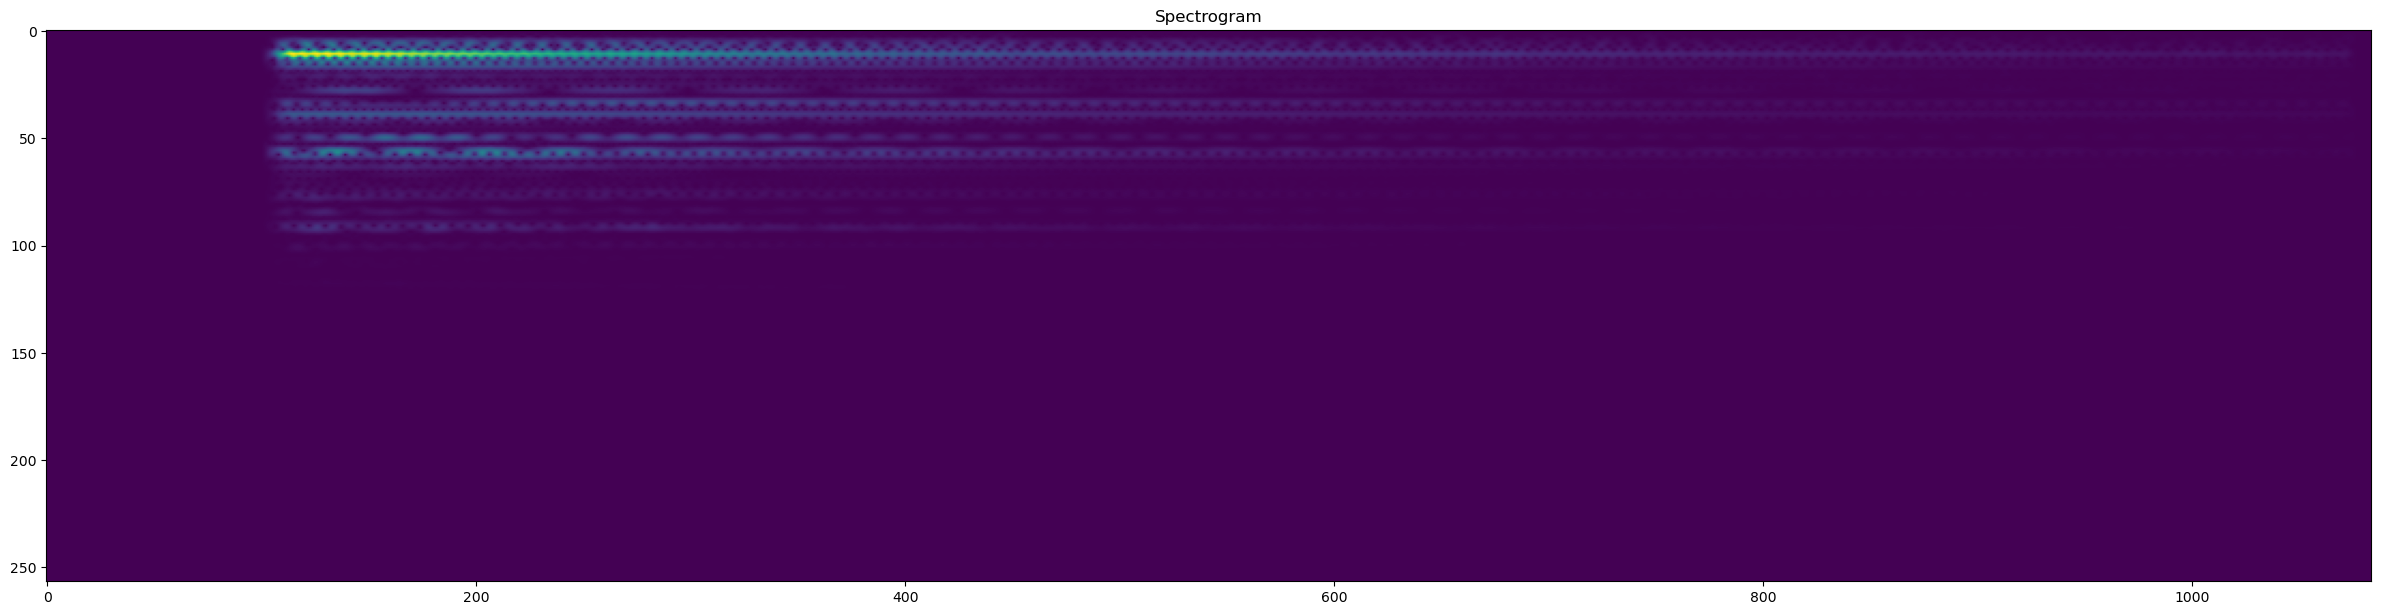

1/1 [==============================] - 0s 74ms/step


array([['F', '0.99424213']], dtype='<U32')

In [106]:
make_pred_custom_chord("dataset_chords/F/f47.wav", loaded_model)

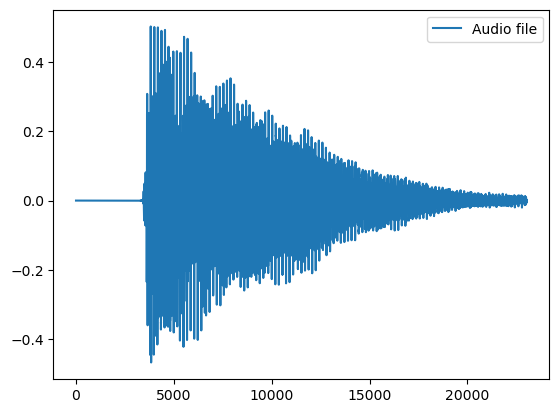

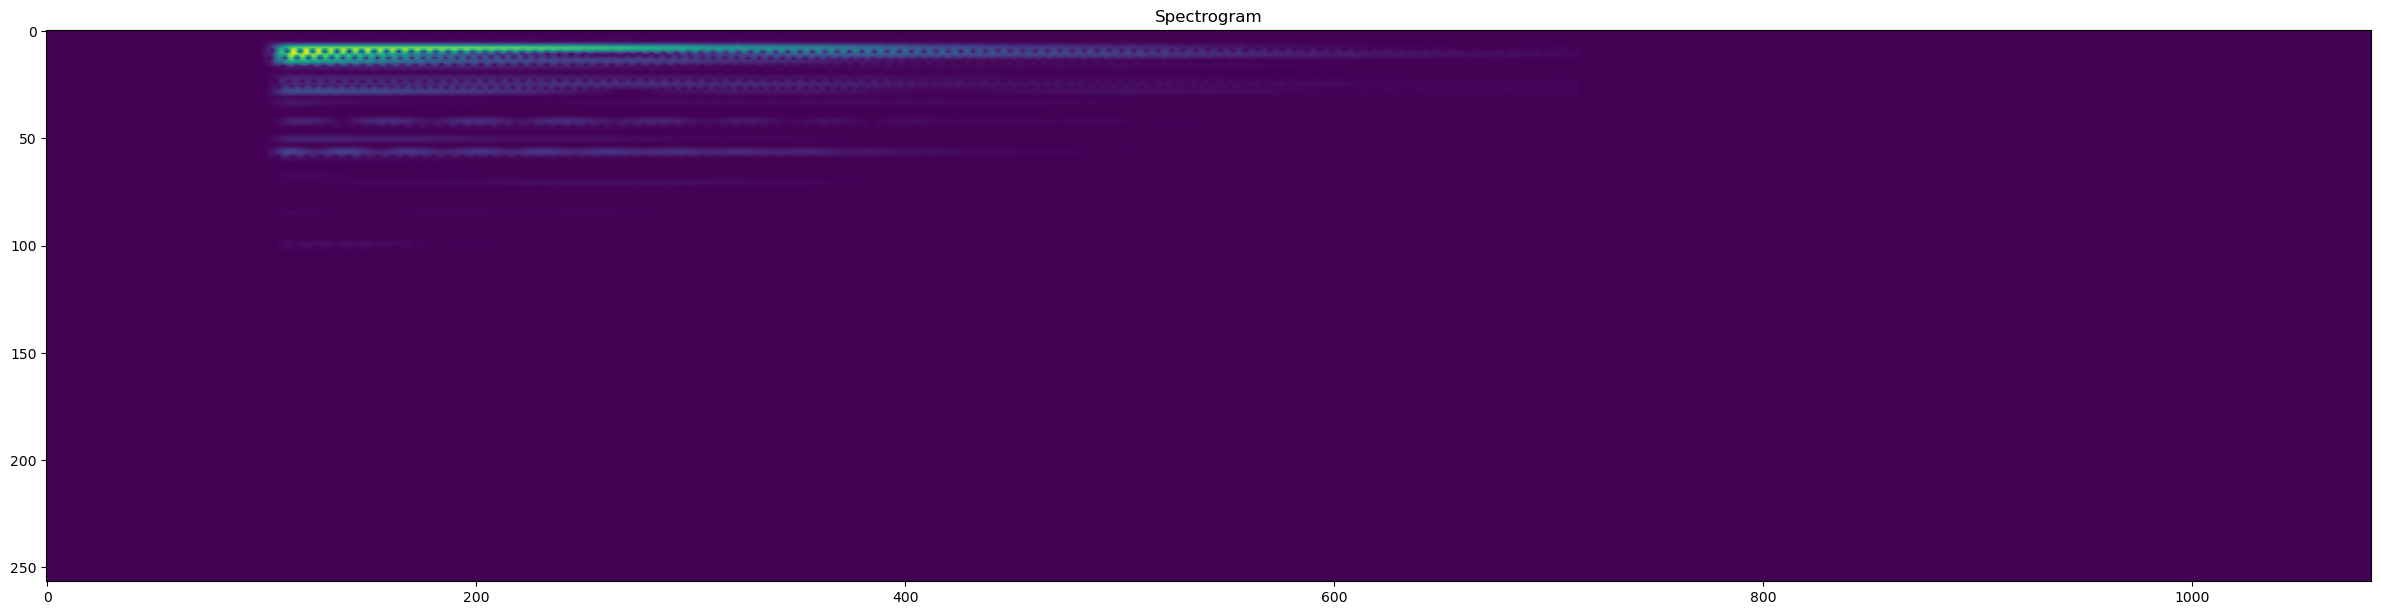

1/1 [==============================] - 0s 69ms/step


array([['F', '0.9846827']], dtype='<U32')

In [107]:
make_pred_custom_chord("dataset_chords/F/f04.wav", loaded_model)

I want to make prediction on a bigger mp3 file by spliting and making predictions through sliding window method

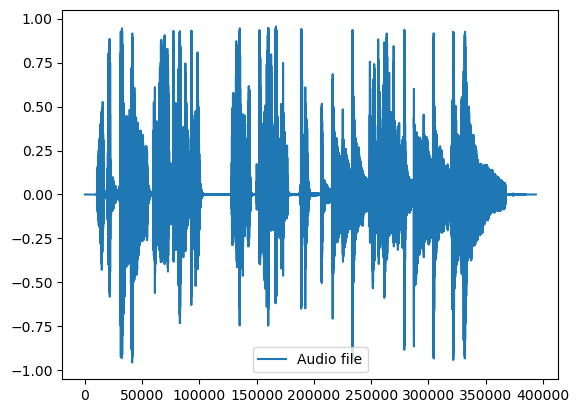

In [108]:
# let's take a look how that file looks
wav = load_wav_file("F_chord_test.mp3")
Audio(wav, rate = 16000)

In [109]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, 
                                                               sequence_length=35000, 
                                                               sequence_stride=35000,
                                                               batch_size=1)

In [110]:
len(audio_slices)

11

In [111]:
sample = audio_slices.as_numpy_iterator().next()

In [112]:
Audio(sample[0], rate = 16000)

In [113]:
audio_slices

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [117]:
slices = []
for sample in audio_slices.as_numpy_iterator():
    slices.append(tf.expand_dims(convert_wav_to_spectrogram(sample[0][0], show = False),axis  =0 ))

In [118]:
slices = tf.data.Dataset.from_tensor_slices(slices)

In [119]:
slices.batch(16)

<_BatchDataset element_spec=TensorSpec(shape=(None, 1, 1084, 257, 1), dtype=tf.float32, name=None)>

In [120]:
slices

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 1084, 257, 1), dtype=tf.float32, name=None)>

In [121]:
len(slices)

11

In [122]:
pred = model.predict(slices)

11/11 [==============================] - 1s 53ms/step


In [123]:
np.argmax(pred,axis = 1)

array([0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1], dtype=int64)

In [124]:
# let's load the mp3 audio file and split it into files of 35000 length
def load_mp3_slited_files(path): 
    wav = load_wav_file(path, waveform=False)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, 
                                                               sequence_length=35000, 
                                                               sequence_stride=35000,
                                                               batch_size=1)
    slices = []
    for sample in audio_slices.as_numpy_iterator():
        slices.append(convert_wav_to_spectrogram(sample[0][0], show = False))
    slices = tf.data.Dataset.from_tensor_slices(slices)
    slices = slices.batch(len(audio_slices))
    return slices

In [125]:
f_chords = load_mp3_slited_files("F_chord_test.mp3")

In [139]:
results = convert_pred_label(model.predict(f_chords))[:, -1]
results

1/1 [==============================] - 0s 478ms/step


array(['A', 'A', 'F', 'F', 'F', 'A', 'A', 'A', 'A', 'A', 'C'], dtype='<U1')

In [143]:
i = 0
for chord in results:
    write  = " {} ".format(chord)
    print(write, end = " ")
#         st.sidebar.success(write)
    i+=1

 A   A   F   F   F   A   A   A   A   A   C  

## Let's test on testing file i have used C chord in this testing audio

In [129]:
testing_chord = load_mp3_slited_files("testing_full_song.wav")

In [130]:
testing_chord

<_BatchDataset element_spec=TensorSpec(shape=(None, 1084, 257, 1), dtype=tf.float32, name=None)>

In [131]:
len(testing_chord)

1

In [132]:
convert_pred_label(loaded_model.predict(testing_chord))[:,-1]

1/1 [==============================] - 3s 3s/step


array(['F', 'F', 'F', 'A', 'F', 'F', 'C', 'A', 'F', 'A', 'A', 'F', 'F',
       'F', 'C', 'F', 'A', 'A', 'F', 'F', 'A', 'C', 'A', 'C', 'A', 'F',
       'F', 'F', 'C', 'C', 'C', 'A', 'F', 'F', 'F', 'A', 'A', 'A', 'F',
       'C', 'F', 'A', 'F', 'F', 'F', 'F', 'A', 'F', 'F', 'A', 'A', 'F',
       'A', 'F', 'F', 'F', 'F', 'F'], dtype='<U1')

In [133]:
convert_prob_label_index(loaded_model.predict(testing_chord))

1/1 [==============================] - 3s 3s/step


array([2, 2, 2, 0, 2, 2, 1, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1,
       0, 1, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 2, 1, 2, 0, 2, 2,
       2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2], dtype=int64)